In [1]:
PROJECT_PATH = '../..'
DATASET_PATH='/home/swei20/cancerHH/AceCanZ/runs/t1/'
# DATASET_PATH = '/scratch/ceph/dobos/data/pfsspec/train/stellar/grid/bosz_hires_test'

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import copy
import umap
from collections import Counter
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [3]:
sys.path.insert(0, PROJECT_PATH)

In [19]:
# from cancer.prepro.data.dataset import Dataset
from util.HH import *
from util.prepro import horner_decode
from util.csvec import CSVec
from cancer.postpro.project import get_umap_pd,get_kmean_lbl,get_pred_stream
from cancer.postpro.clustering import *

In [6]:
maskId=26

In [8]:
mask=np.loadtxt(DATASET_PATH+f'maskId{maskId}.txt')

In [10]:
stream=np.loadtxt(DATASET_PATH+f'teststream{maskId}.txt')

In [11]:
streamLen=stream.shape[0]
streamLen

1276341

In [12]:
alpha=0.4
base=22
ftr_len=8
dtype='uint64'
EXACT='exact'

In [13]:
HH_pd=pd.read_csv(f'{DATASET_PATH}/HH_pd_b{base}_{EXACT}.csv')

In [14]:
HH_pd

0     1     2     3     4     5     6     7            HH      freq  \
0       3.0   4.0  12.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  237391.0   
1       0.0  11.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  188734.0   
2       3.0   4.0  11.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  162228.0   
3       0.0  11.0  14.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  158326.0   
4       0.0  12.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  143776.0   
...     ...   ...   ...   ...   ...   ...   ...   ...           ...       ...   
109930  1.0  13.0  15.0  15.0   8.0  11.0  13.0  12.0  3.146496e+10       1.0   
109931  1.0   8.0  14.0  14.0   8.0  11.0  13.0  11.0  2.897060e+10       1.0   
109932  0.0  12.0  15.0  10.0  11.0  11.0  12.0  11.0  2.885788e+10       1.0   
109933  2.0  17.0  15.0   8.0  12.0  11.0  12.0  11.0  2.885809e+10       1.0   
109934  2.0  17.0  15.0   8.0  12.0  12.0  12.0  11.0  2.886324e+10       1.0   

                rk        ra  
0         237391.0  0.008417  
1         426125.0  0.015109  
2         588353.0  0.020861  
3         746679.0  0.026475  
4         890455.0  0.031573  
...            ...       ...  
109930  28202814.0  1.000000  
109931  28202815.0  1.000000  
109932  28202816.0  1.000000  
109933  28202817.0  1.000000  
109934  28202818.0  1.000000  

[109935 rows x 12 columns]

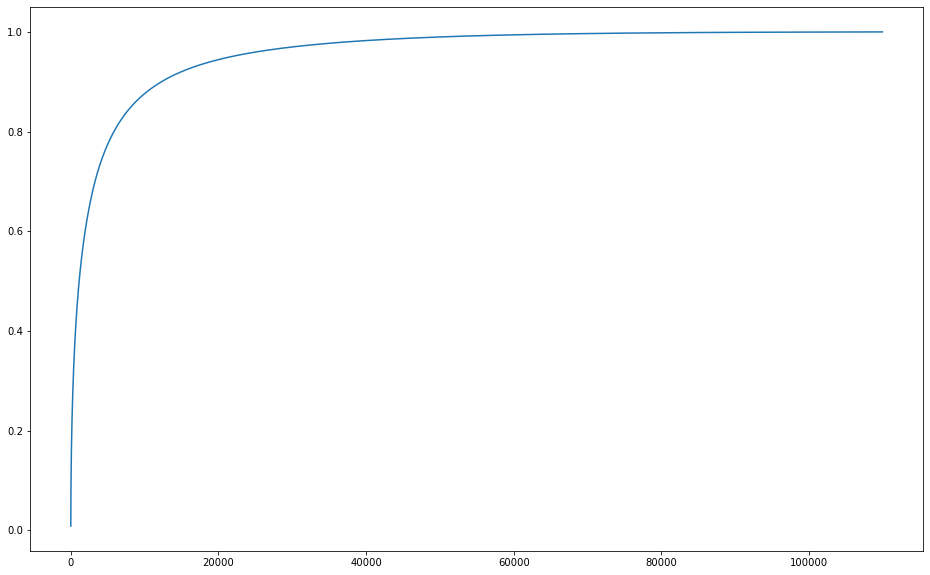

In [51]:
plt.plot(HH_pd['ra'])

In [75]:
np.linspace(0.2,0.9,3)

array([0.2 , 0.55, 0.9 ])

In [ ]:
def process_kmean(exact_pdh,  N_clusters = [3,10], u1 = 'u1', u2 = 'u2', k_cluster = 'kmean', weight=None):
    k_names = []
    umap_result = exact_pdh.loc[:,[u1, u2 ]].values
    l_cluster = len(N_clusters)
    f, axes = plt.subplots(1,l_cluster,figsize= (16,5) )
    for i in range(l_cluster):
        N_cluster = N_clusters[i]
        k_name = f'k{N_cluster}'
        k_names += [k_name]
        kmeans = KMeans(n_clusters=N_cluster,n_init=30, algorithm='elkan')
        kmeans.fit(umap_result, sample_weight = weight)
        exact_pdh[k_name] = kmeans.labels_ +1
        sns.scatterplot(
            x=u1, y=u2,
            hue= k_name , marker='x',s=5,
            palette=sns.color_palette("muted", N_cluster),
            data=exact_pdh,
            legend="full",
            ax = axes[i]
            # alpha=0.3 
            )
    # print(exact_pdh.loc[[0,1]])
    return k_names,kmeans

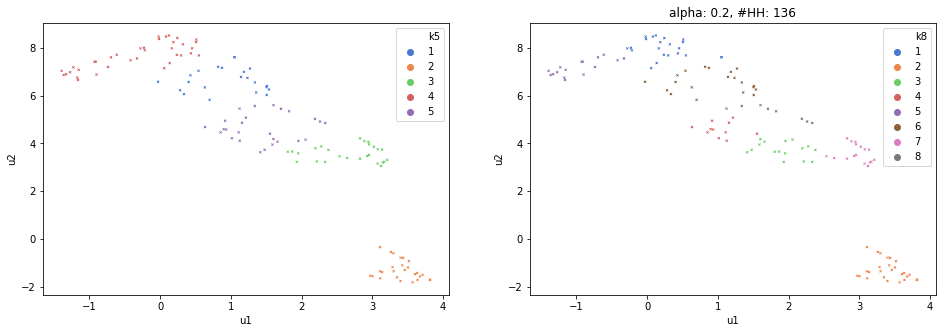

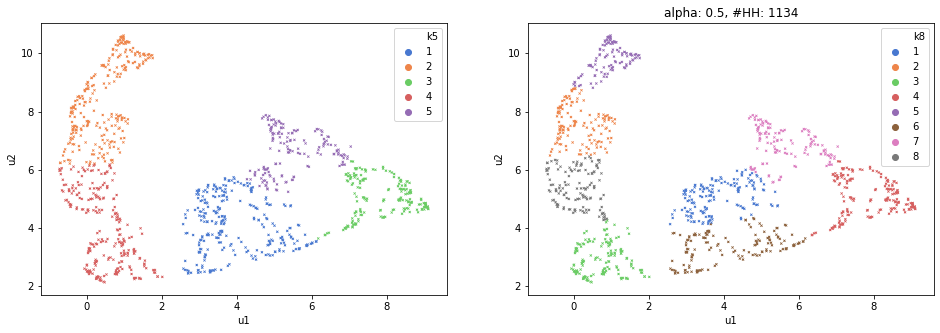

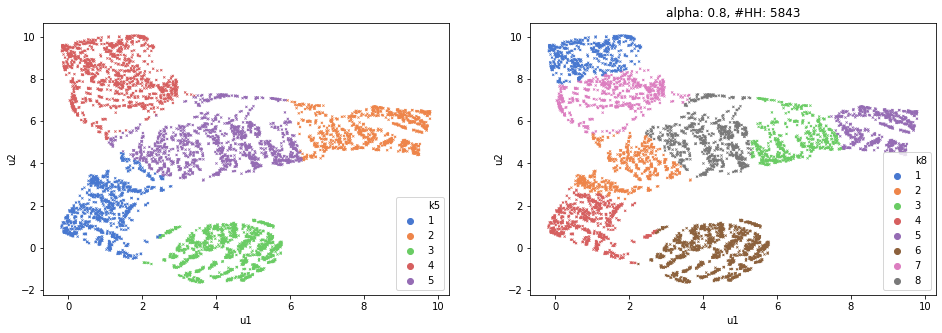

In [81]:
for alpha in [0.2,0.5,0.8]:
    HH_pdh=HH_pd[HH_pd['ra']<alpha]        
    umapT=get_umap_pd(HH_pdh, list(range(8)))        
    process_kmean(HH_pdh,  N_clusters = [5,8], u1 = 'u1', u2 = 'u2', k_cluster = 'kmean', weight=None) 
    plt.title(f'alpha: {alpha}, #HH: {HH_pdh.shape[0]}')
    plt.show()

In [82]:
HH_pdh

0     1     2     3     4     5     6     7            HH      freq  \
0     3.0   4.0  12.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  237391.0   
1     0.0  11.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  188734.0   
2     3.0   4.0  11.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  162228.0   
3     0.0  11.0  14.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  158326.0   
4     0.0  12.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  143776.0   
...   ...   ...   ...   ...   ...   ...   ...   ...           ...       ...   
5838  1.0  12.0  16.0  10.0  11.0  11.0  12.0  13.0  3.384659e+10     773.0   
5839  2.0   7.0  13.0   9.0  12.0  13.0  12.0  12.0  3.136276e+10     773.0   
5840  1.0  16.0  15.0  14.0  12.0  13.0  12.0  12.0  3.136282e+10     772.0   
5841  3.0   6.0  15.0  14.0  12.0  12.0  12.0  12.0  3.135766e+10     772.0   
5842  1.0   8.0  12.0  11.0  12.0  11.0  11.0  12.0  3.123910e+10     772.0   

              rk        ra        u1        u2  k5  k8  
0       237391.0  0.008417  9.720662  6.440035   2   5  
1       426125.0  0.015109  5.197400 -0.031497   3   6  
2       588353.0  0.020861  9.779303  6.387942   2   5  
3       746679.0  0.026475  5.472912  0.440376   3   6  
4       890455.0  0.031573  4.789161  0.151849   3   6  
...          ...       ...       ...       ...  ..  ..  
5838  22558763.0  0.799876  4.672195  5.511446   5   8  
5839  22559536.0  0.799904  6.677987  6.714827   2   3  
5840  22560308.0  0.799931  2.260834  3.723142   5   2  
5841  22561080.0  0.799958  8.520410  6.602456   2   5  
5842  22561852.0  0.799986  8.800634  5.124788   2   5  

[5843 rows x 16 columns]

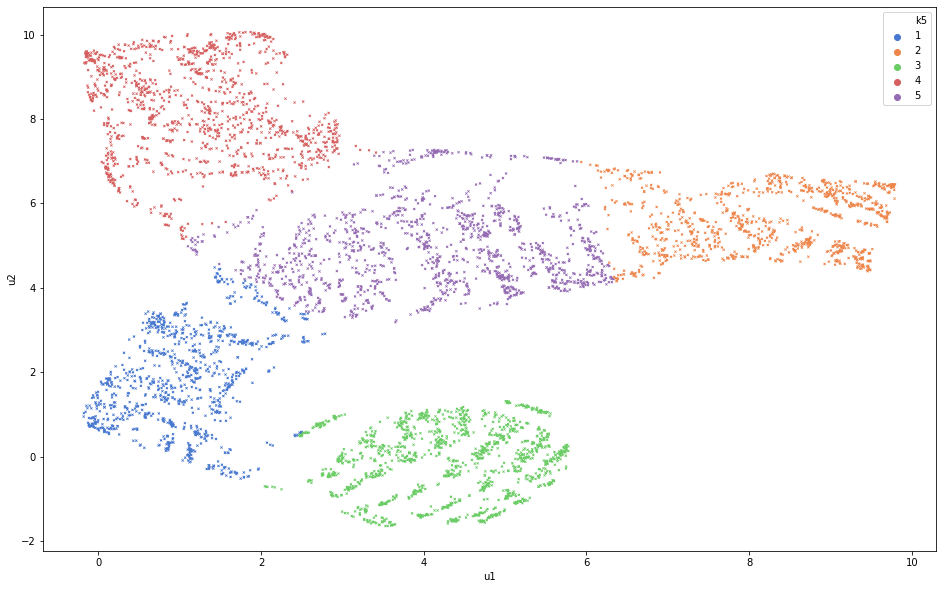

In [88]:
sns.scatterplot(
            x="u1", y="u2",
            hue=f'k{nCluster}'  , marker='x',s=5,
            palette=sns.color_palette("muted", nCluster),
            data=HH_pdh,
            legend="full")

In [24]:
mask.shape

(1349376,)

In [39]:
def plott(mask):
    plt.matshow(mask.reshape((1004,1344)))

In [83]:
nCluster=8
codedImg8=get_pred_stream(stream, mask, HH_pdh, 'k'+str(nCluster), val = 'HH', bg = -1, color = 0, sgn = 1 )

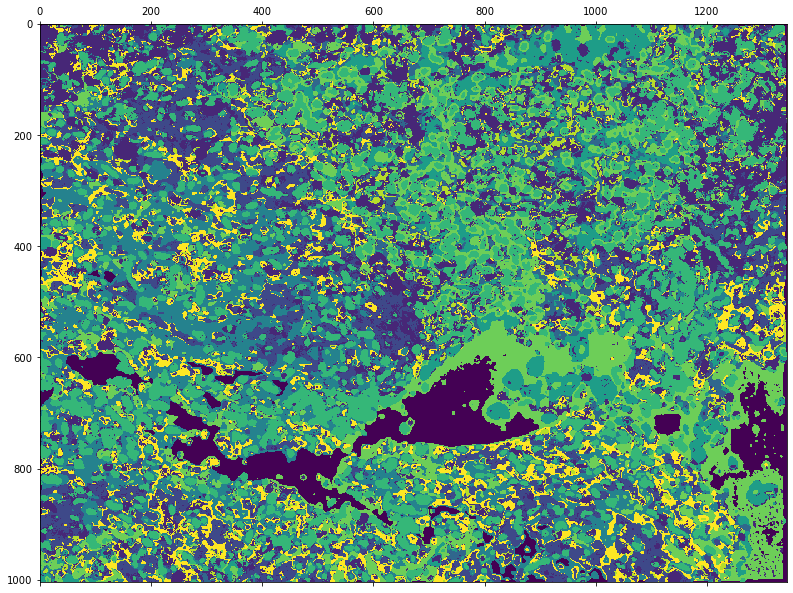

In [84]:
plott(codedImg8)

In [85]:
HH_pdh2=HH_pd[HH_pd['ra']<0.5]        
umapT2=get_umap_pd(HH_pdh2, list(range(8)))        
process_kmean(HH_pdh2,  N_clusters = [2,8], u1 = 'u1', u2 = 'u2', k_cluster = 'kmean', weight=None) 
nCluster=8
codedImg8=get_pred_stream(stream, mask, HH_pdh, 'k'+str(nCluster), val = 'HH', bg = -1, color = 0, sgn = 1 )

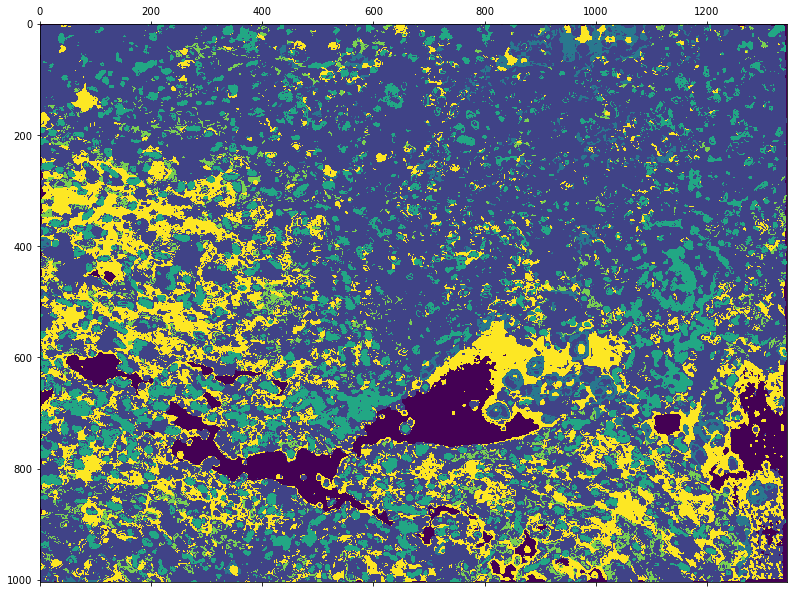

In [86]:
plott(codedImg)

In [89]:
def plot_3_clusters(final_c10, idx1 =3, idx2 = 4,idx3=2):
    s1 = (final_c10 == idx1)*(1)
    s2 = (final_c10 == idx2)* 1
    s3 = (final_c10 == idx3)* 1

    masked = s1 - s2-s3
    plt.matshow(np.reshape(masked, (1004,1344)))
    plt.title(f'cluster yellow: {idx1}  and blue: {idx2}')
#     plt.savefig(f'{name}/p{idx1}m{idx2}.png', dpi = 1000)
    return None

In [93]:
from cancer.plot import *

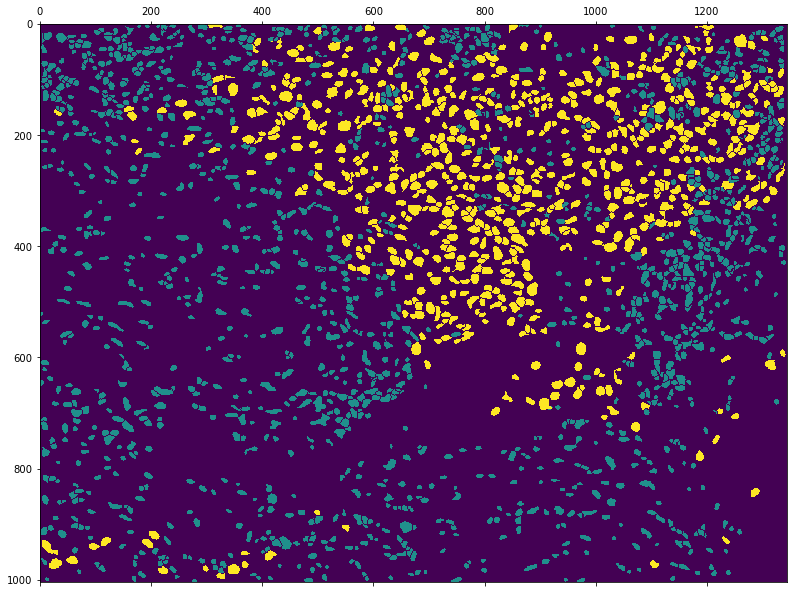

In [95]:
plt.matshow(lbl)

In [124]:
def get_coded_plots(HH_pd, alpha, n0,n1):
    HH_pdh=HH_pd[HH_pd['ra']<alpha]        
    umapT=get_umap_pd(HH_pdh, list(range(8)));      
    process_kmean(HH_pdh,  N_clusters = [n0,n1], u1 = 'u1', u2 = 'u2', k_cluster = 'kmean', weight=None) 
    plt.title(f'alpha: {alpha}, #HH: {HH_pdh.shape[0]}')
    plt.show()
    codedImg=get_pred_stream(stream, mask, HH_pdh, 'k'+str(n0), val = 'HH', bg = -1, color = 0, sgn = 1 )
    pred=codedImg.reshape((1004,1344))
    plot_CN_all(pred,list(range(n0)), l128,l64, sns.color_palette('muted', n0))    
    return HH_pdh

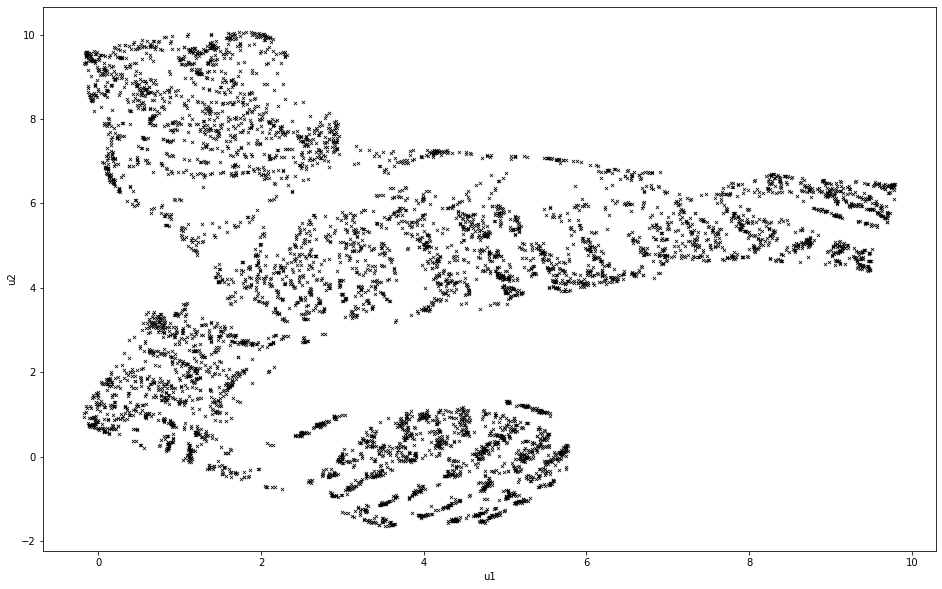

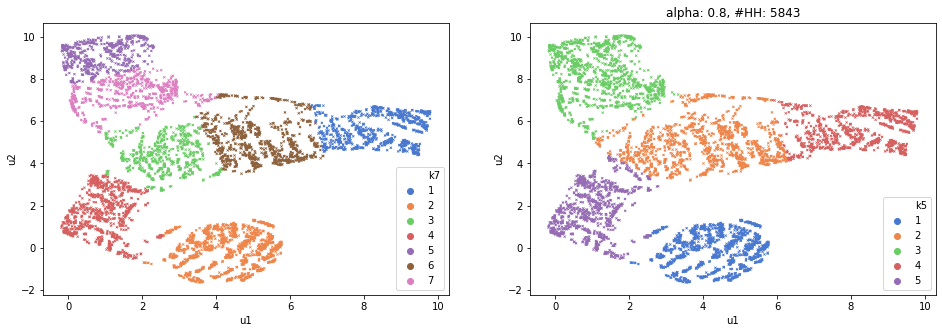

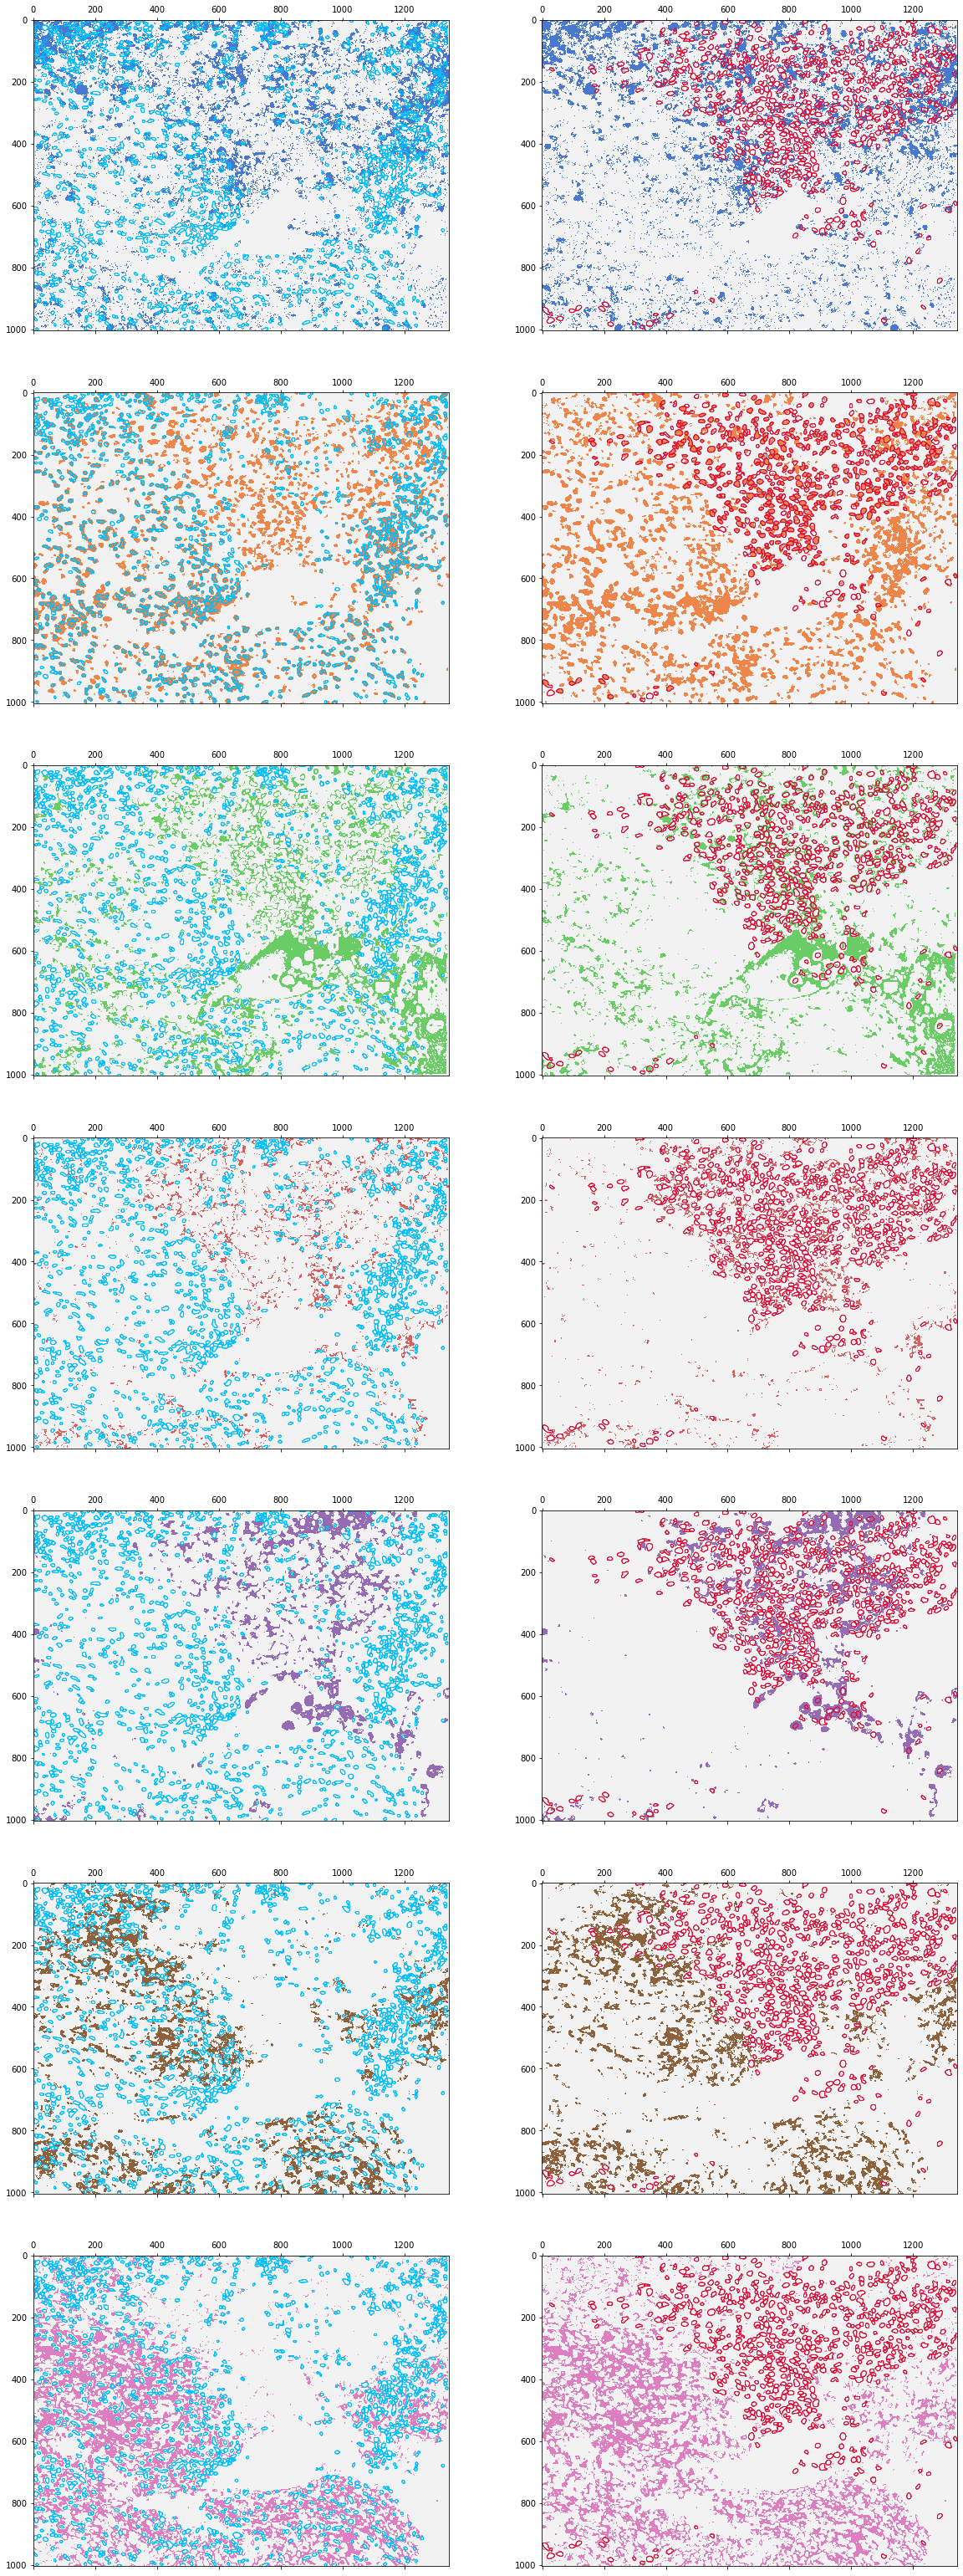

In [126]:
alpha, n0, n1 = 0.8, 7, 5
HH_pdh8=get_coded_plots(HH_pd, alpha, n0,n1)

In [105]:
nCluster=8
pred=codedImg8.reshape((1004,1344))
cmap_k=sns.color_palette('muted', nCluster)


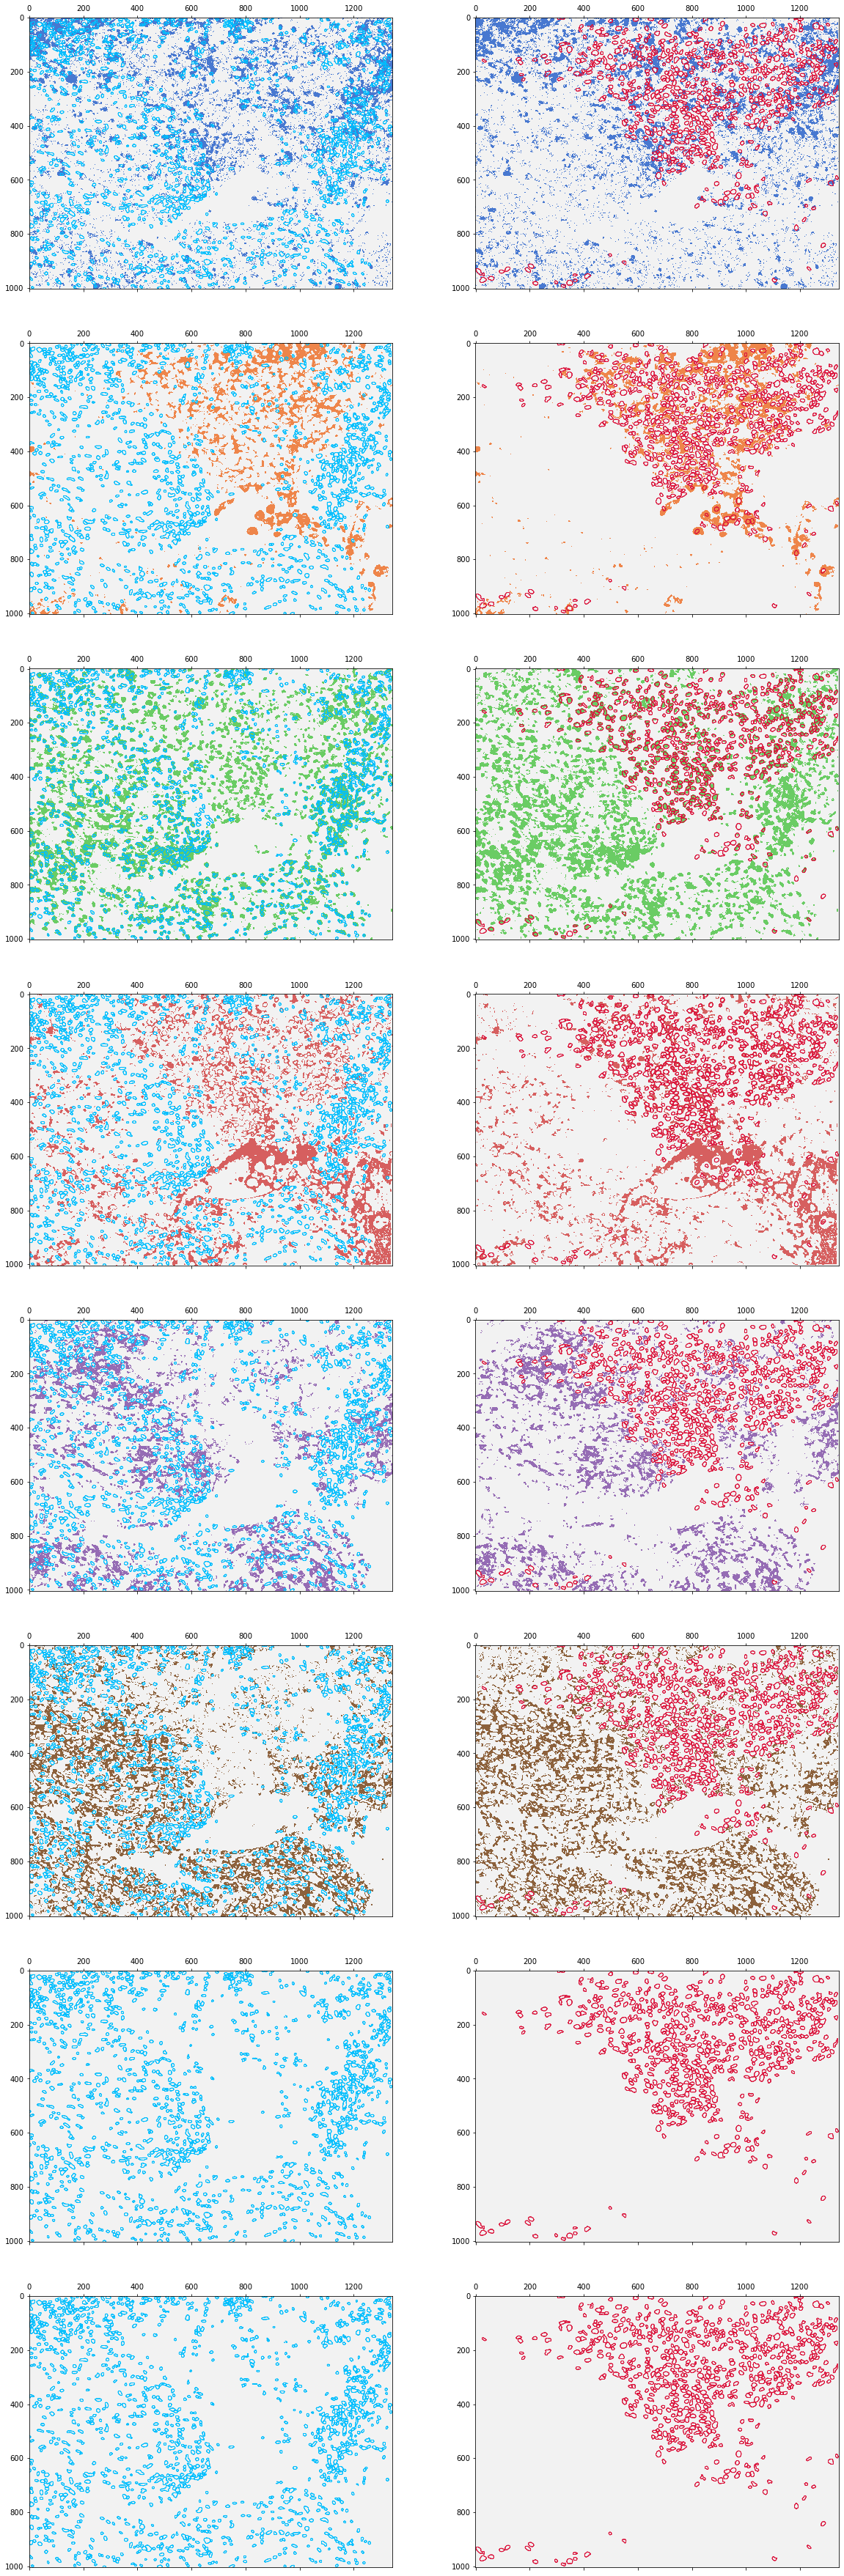

In [106]:
pred=codedImg8.reshape((1004,1344))
plot_CN_all(pred,list(range(8)), l128,l64, cmap_k)

(['k2', 'k8'], KMeans(algorithm='elkan', n_init=30))

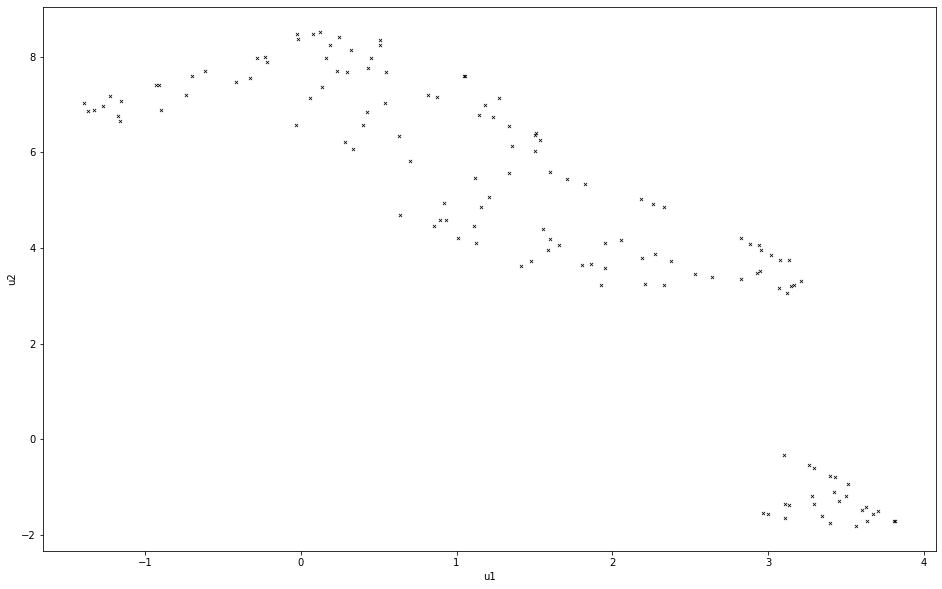

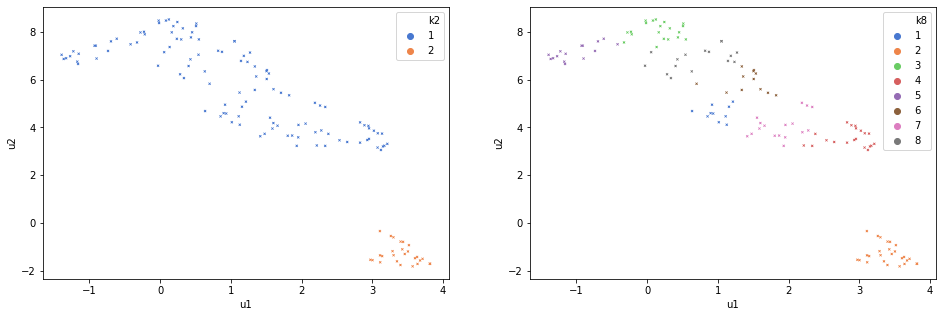

In [112]:
HH_pdh2=HH_pd[HH_pd['ra']<0.5]        
umapT2=get_umap_pd(HH_pdh2, list(range(8)))        
process_kmean(HH_pdh2,  N_clusters = [2,8], u1 = 'u1', u2 = 'u2', k_cluster = 'kmean', weight=None) 

In [113]:
nCluster=2
codedImg2=get_pred_stream(stream, mask, HH_pdh2, 'k'+str(nCluster), val = 'HH', bg = -1, color = 0, sgn = 1 )

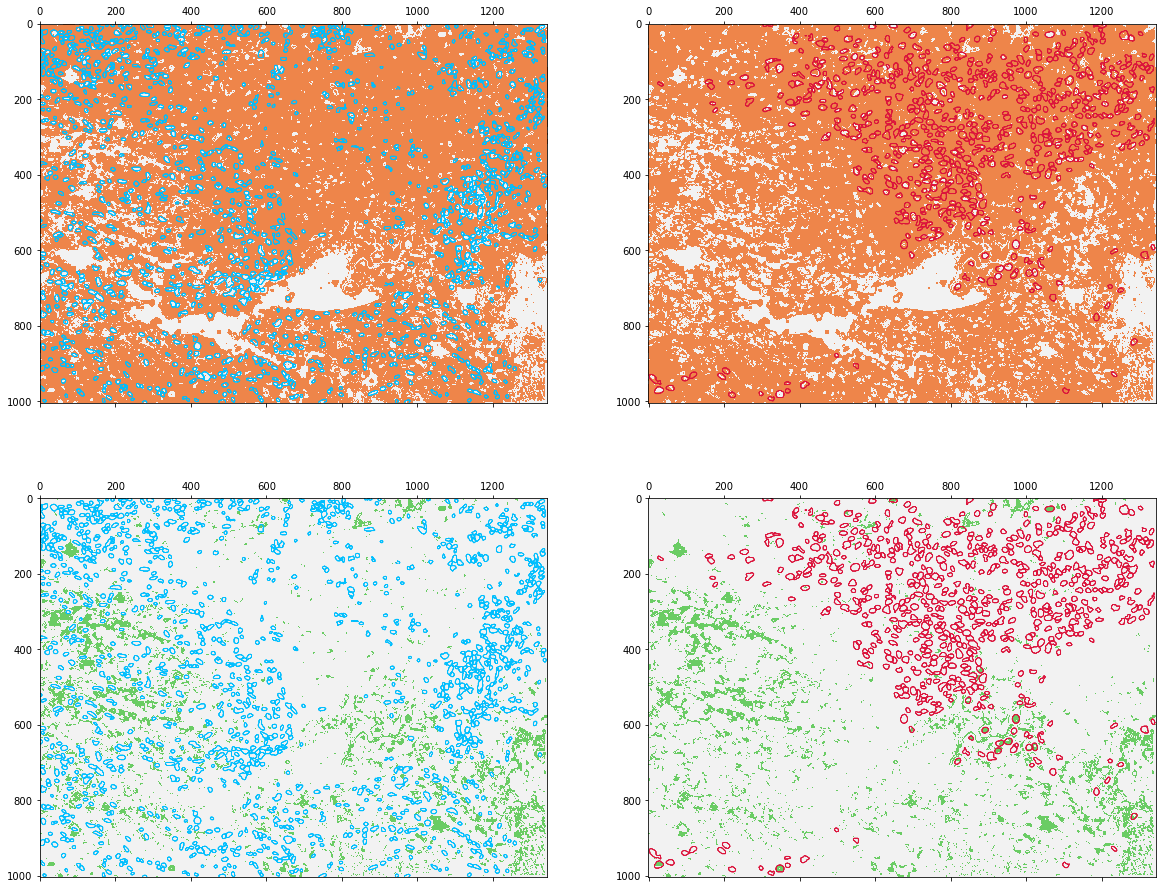

In [118]:
pred=codedImg2.reshape((1004,1344))
plot_CN_all(pred,list(range(2)), l128,l64, cmap_k[1:])

In [ ]:
pd.DataFrame

In [130]:
mask.shape

(1349376,)

In [ ]:
def plot_clusters(stream_1D, mask, pd,  k_cluster, val = 'val', bg = -1, color = 0, sgn = 1 ):
    mask=mask.astype('bool')
    HHvals = np.array(pd[val])
    HHcluster = np.array(pd[k_cluster])
    masked_streams = np.zeros(np.shape(stream_1D))
    for idx, val in enumerate( HHvals): 
        label = HHcluster[idx]
        masked_streams = np.where(stream_1D != val, masked_streams, color +sgn * label)
    final_umap = np.ones(mask.shape) * bg
    final_umap[mask] = masked_streams
    return final_umap, masked_streams 

In [133]:
HH_pdh_gluviz=HH_pdh[]

0     1     2     3     4     5     6     7            HH      freq  \
0     3.0   4.0  12.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  237391.0   
1     0.0  11.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  188734.0   
2     3.0   4.0  11.0  12.0  12.0  12.0  12.0  12.0  3.135764e+10  162228.0   
3     0.0  11.0  14.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  158326.0   
4     0.0  12.0  13.0  12.0  11.0  12.0  12.0  13.0  3.385177e+10  143776.0   
...   ...   ...   ...   ...   ...   ...   ...   ...           ...       ...   
5838  1.0  12.0  16.0  10.0  11.0  11.0  12.0  13.0  3.384659e+10     773.0   
5839  2.0   7.0  13.0   9.0  12.0  13.0  12.0  12.0  3.136276e+10     773.0   
5840  1.0  16.0  15.0  14.0  12.0  13.0  12.0  12.0  3.136282e+10     772.0   
5841  3.0   6.0  15.0  14.0  12.0  12.0  12.0  12.0  3.135766e+10     772.0   
5842  1.0   8.0  12.0  11.0  12.0  11.0  11.0  12.0  3.123910e+10     772.0   

              rk        ra        u1        u2  k5  k8  
0       237391.0  0.008417  9.720662  6.440035   2   5  
1       426125.0  0.015109  5.197400 -0.031497   3   6  
2       588353.0  0.020861  9.779303  6.387942   2   5  
3       746679.0  0.026475  5.472912  0.440376   3   6  
4       890455.0  0.031573  4.789161  0.151849   3   6  
...          ...       ...       ...       ...  ..  ..  
5838  22558763.0  0.799876  4.672195  5.511446   5   8  
5839  22559536.0  0.799904  6.677987  6.714827   2   3  
5840  22560308.0  0.799931  2.260834  3.723142   5   2  
5841  22561080.0  0.799958  8.520410  6.602456   2   5  
5842  22561852.0  0.799986  8.800634  5.124788   2   5  

[5843 rows x 16 columns]

In [135]:
HH_pdh.to_csv('HHgluviz.csv', heading=False)

TypeError: to_csv() got an unexpected keyword argument 'heading'

In [136]:
maskT=copy.deepcopy(mask)

In [137]:
maskT[maskT!=0]=stream

In [140]:
maskT=maskT.reshape((1004,1344))

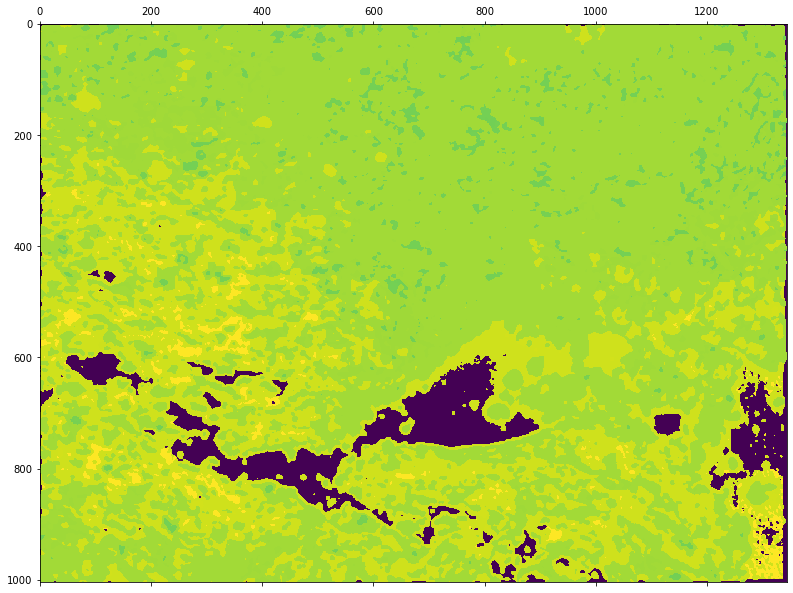

In [141]:
plt.matshow(maskT
           )

In [128]:
stream

(1276341,)

In [143]:
np.savetxt('maskT.dat',maskT)